<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 4</h2>

In this part you will take your aligned images and combine them using the same tools that we used to combine our flats.

We took short exposures of every target to deal with saturation.  Note, however, that we can't just combine the short and long exposures and expect the saturation to go away.  In principle we would need to produced combinations of the short and long exposures separately and use photometry from faint stars from our long exposures and from the saturated stars from our bright exposures.  For the sake of expediency we are going to instead just use the long exposures and ignore the brightest stars.

You will need to install photutils with 

*conda install photutils -c astropy*


In [2]:
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from matplotlib import pyplot as plt
from ccdproc import Combiner
from astropy.io import ascii
from astropy.io import fits
import os, glob, time

In [3]:
#this specifies the reduction directory
#****
#put your own path
redpath = "/home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/"

First we write a routine to read in images.

In [4]:
def readimage(filename):
    imgfile = os.path.join('{}'.format(redpath), filename)
    print('Reading {}'.format(imgfile))
    img, hdr = fits.getdata(imgfile, header=True)
    return img,imgfile,hdr

This routine will display an image

In [5]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

This function will do the combination.  

In [6]:
def im_combine(comblist,outfile):
    #filelist is the name of a text file that contains a list of all the files to combine
    comblistpath = redpath + comblist
    
    #initialize a list of files to combine
    comb_imlist = []

    #this way of opening the file ensures that it closes after the loop is done.
    with open(comblistpath,'r') as fp:
        
        #read first line
        iline = 0
        line = fp.readline()

        #build the combine list of all images
        #read every subsequent line
        while line:
            #this removes the trailing newline charactter and converts the output list to a scalar
            imname = line.split()
            imname = imname[0]
            
            #create the image name, including the path
            imstr = redpath + imname
            #read that into a CCDData object.  This allows you to specify a unit
            im = CCDData.read(imstr)

            #read in the image headers
            imtest, hdr = fits.getdata(imstr, header=True) 
            
            #normalize each image by its exposure time.  This allows you to combine images of 
            #different exposure times.
            im = im.divide(hdr['EXP_TIME'] * u.electron)
            
            #make a list of all the CCDData instances of each image
            comb_imlist = comb_imlist + [im]
        
        
            line = fp.readline()
            iline = iline + 1

    #Combiner list of all bias images
    im_combiner = Combiner(comb_imlist)


    #generate a median combined image
    combined_img = im_combiner.median_combine()

    #now write out this file
    combined_imgpath = redpath + outfile

    #Change the exposure time keyword to reflect that these images have been normalized to 1 second
    hdr['EXP_TIME'] = 1.0
    #this takes the header of the last file in the list writes it as the header of the combined file.
    combined_img.meta = hdr
    combined_img.write(combined_imgpath, overwrite=True)


In [10]:
#*********
#Here you will need to provide names of lists of your images, and the name of an output file 
#for each combined image
comb_imname_ngc7128_V = 'ngc7128_V_comb.fits'
im_combine('ngc7128_v_comblist',comb_imname_ngc7128_V)
comb_imname_ngc7128_B = 'ngc7128_B_comb.fits'
im_combine('ngc7128_b_comblist',comb_imname_ngc7128_B)
comb_imname_King20_V = 'King20_V_comb.fits'
im_combine('King20_V_comblist',comb_imname_King20_V)
comb_imname_King20_B = 'ngc7128_B_comb.fits'
im_combine('King20_B_comblist',comb_imname_King20_B)

<h3> Determine the Astrometry of your image </h3>
   
"Astrometry" is the process of determining where your data are pointing, i.e.,figuring out the transformation matrix between pixel coordinates (x,y) and celestial coordinates (RA,Dec), which has a long, rich history. In a nutshell, this transformation matrix is determined by comparing the observed positions of stars (or other reference sources) against their known positions (i.e., using an external, calibrated catalog).

Needless to say there are many intricacies involved in astrometry, which I encourage you to delve into.  But for now we can proceed with just the basics and use the [astrometry.net](http://astrometry.net) engine to determine the astrometric solution of our data.

In [11]:
#******
#This reads in images into variables that we will use.  You will need to do this for
#every image that you combined
img_ngc7128_V, imgfile_ngc7128_V, hdr_ngc7128_V = readimage(comb_imname_ngc7128_V)
img_ngc7128_B, imgfile_ngc7128_B, hdr_ngc7128_B = readimage(comb_imname_ngc7128_B)
img_King20_V, imgfile_King20_V, hdr_King20_V = readimage(comb_imname_King20_V)
img_King20_B, imgfile_King20_B, hdr_King20_B = readimage(comb_imname_King20_B)

Reading /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/ngc7128_V_comb.fits
Reading /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/ngc7128_B_comb.fits
Reading /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/King20_V_comb.fits
Reading /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/ngc7128_B_comb.fits


First, we need the observed positions of the stars in this image, but in order to detect those stars we first have to model and subtract the sky background from the data.  This is because we want to detect stars at a certain level above the background and if the background varies across the image this becomes hard.  So we need to create an image with the mean background counts removed.

We'll build the sky background by measuring the median pixel value in a "low-resolution" mesh grid, which we will then interpolate onto the original resolution of the image. For additional details see the photutils tutorial on Background Estimation.

In [12]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

You will need to repeat these commands for each combined image and band combination

In [13]:
#***********
bkg_ngc7128_V = get_sky_background(img_ngc7128_V, verbose=True)
bkg_ngc7128_B = get_sky_background(img_ngc7128_B, verbose=True)
bkg_King20_V = get_sky_background(img_King20_V, verbose=True)
bkg_King20_B = get_sky_background(img_King20_B, verbose=True)

Sky background median = 2.713, rms = 0.062 electrons.
Sky background median = 2.296, rms = 0.057 electrons.
Sky background median = 2.633, rms = 0.062 electrons.
Sky background median = 2.296, rms = 0.057 electrons.


In [14]:
#***********
img_ngc7128_V_nosky = img_ngc7128_V - bkg_ngc7128_V.background
img_ngc7128_B_nosky = img_ngc7128_B - bkg_ngc7128_B.background
img_King20_V_nosky = img_King20_V - bkg_King20_V.background
img_King20_B_nosky = img_King20_B - bkg_King20_B.background

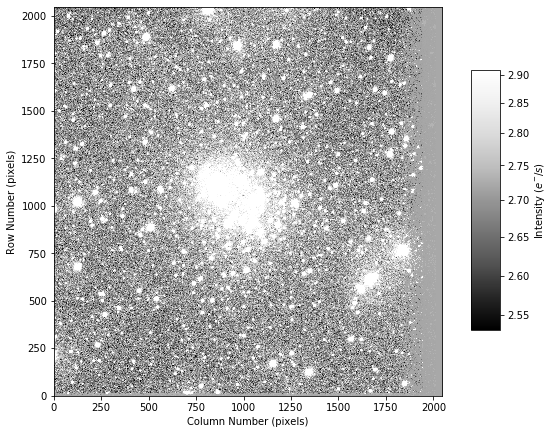

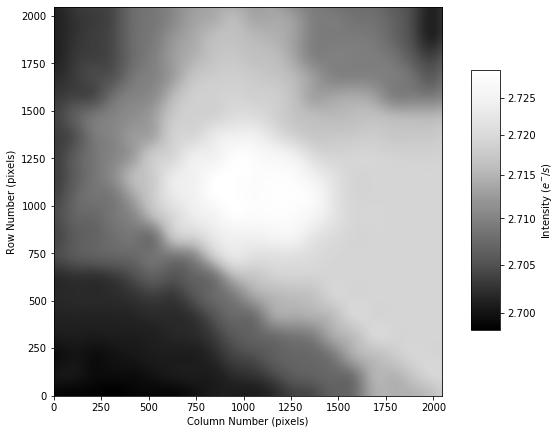

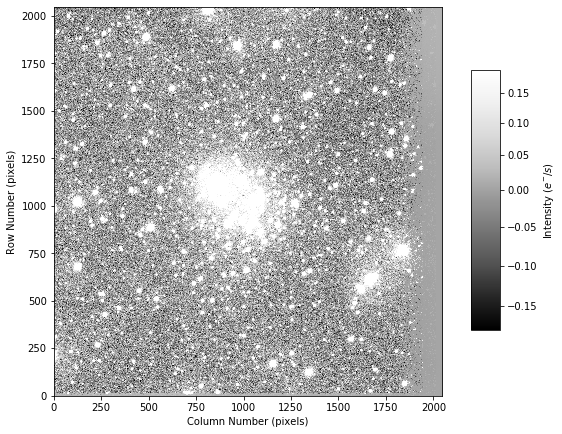

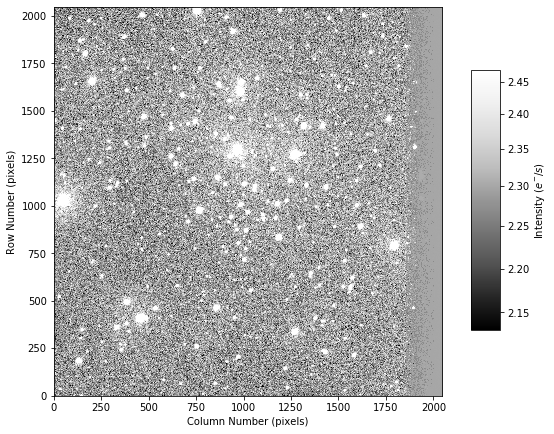

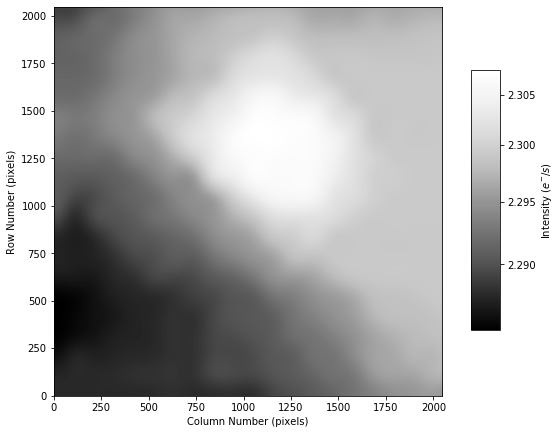

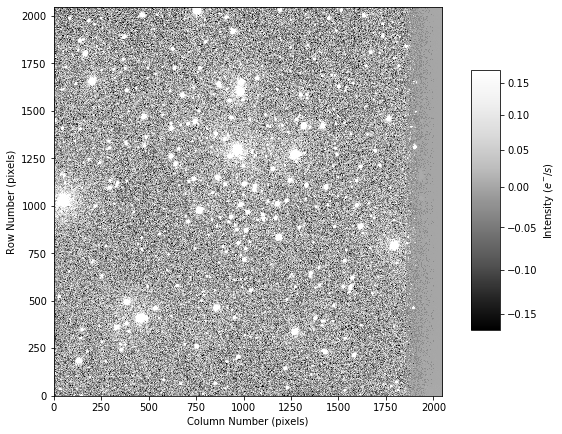

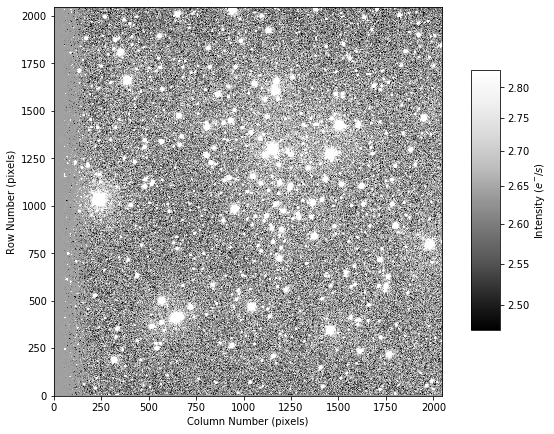

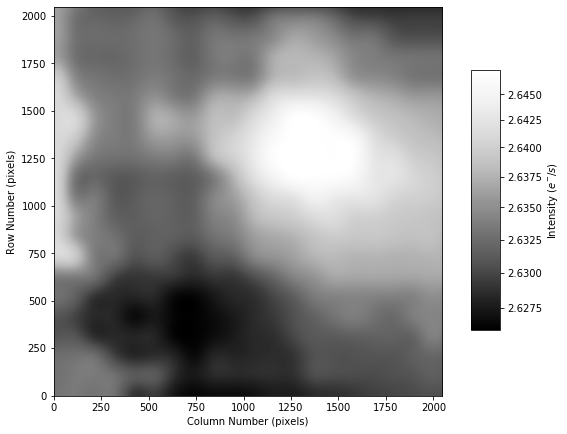

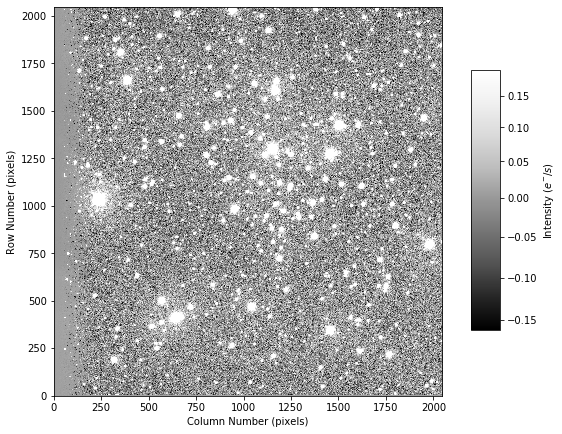

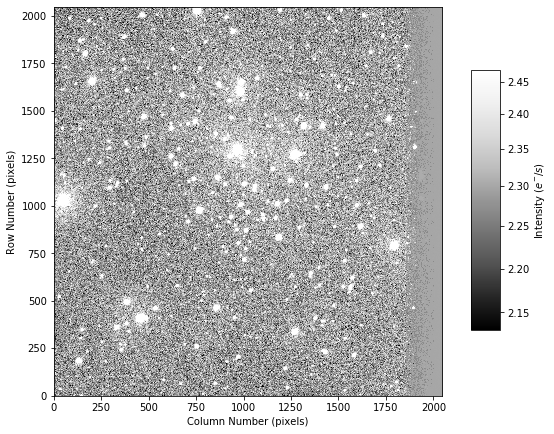

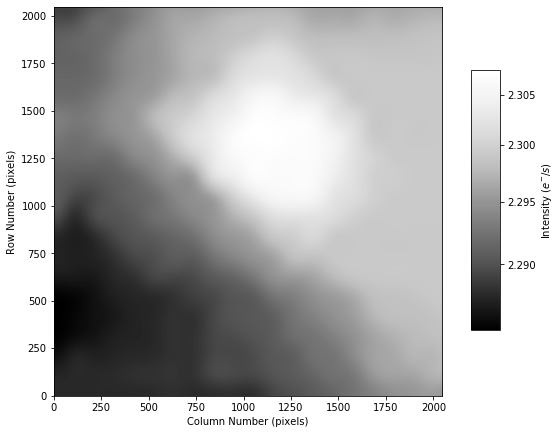

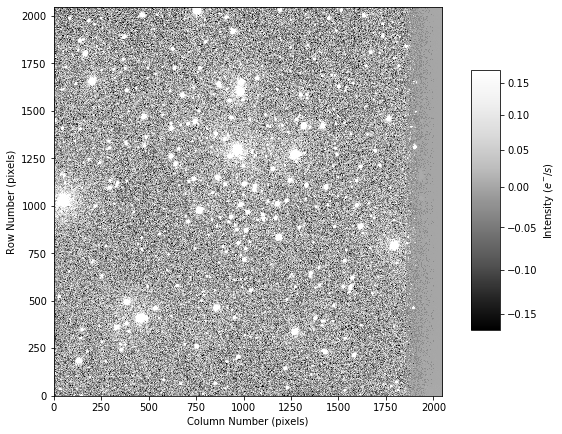

In [15]:
#***********
display_image(img_ngc7128_V, calibrated=True)
display_image(bkg_ngc7128_V.background, calibrated=True)
display_image(img_ngc7128_V_nosky,calibrated=True)

display_image(img_ngc7128_B, calibrated=True)
display_image(bkg_ngc7128_B.background, calibrated=True)
display_image(img_ngc7128_B_nosky,calibrated=True)

display_image(img_King20_V, calibrated=True)
display_image(bkg_King20_V.background, calibrated=True)
display_image(img_King20_V_nosky,calibrated=True)

display_image(img_King20_B, calibrated=True)
display_image(bkg_King20_B.background, calibrated=True)
display_image(img_King20_B_nosky,calibrated=True)
#now write out this file
bkgsub_imname = comb_imname_ngc7128_V.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = redpath + bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_ngc7128_V['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_ngc7128_V_nosky, hdr_ngc7128_V, overwrite=True)

bkgsub_imname = comb_imname_ngc7128_B.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = redpath + bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_ngc7128_B['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_ngc7128_B_nosky, hdr_ngc7128_B, overwrite=True)

bkgsub_imname = comb_imname_King20_V.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = redpath + bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_King20_V['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_King20_V_nosky, hdr_King20_V, overwrite=True)

bkgsub_imname = comb_imname_King20_B.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = redpath + bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_King20_B['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_King20_B_nosky, hdr_King20_B, overwrite=True)





This routine makes histogrames of the original and background subtracted images.

In [39]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

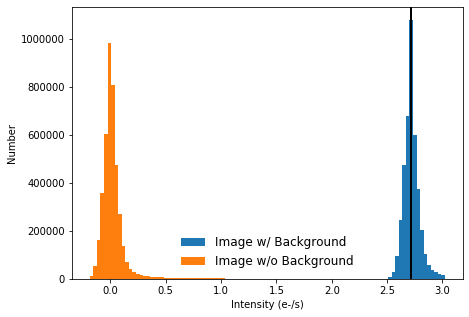

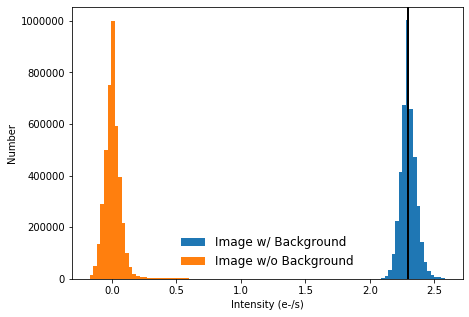

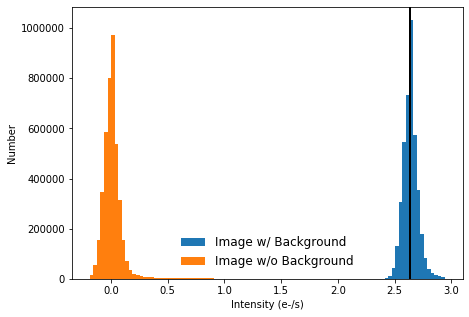

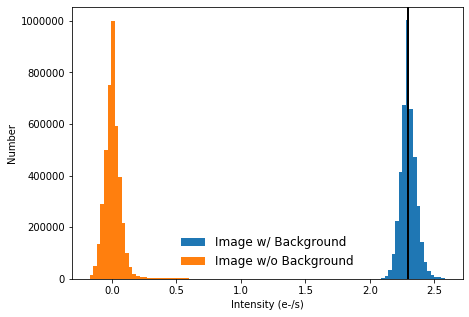

In [40]:
#***********
qa_background(img_ngc7128_V, img_ngc7128_V_nosky, bkg_ngc7128_V)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky, bkg_ngc7128_B)
qa_background(img_King20_V, img_King20_V_nosky, bkg_King20_V)
qa_background(img_King20_B, img_King20_B_nosky, bkg_King20_B)

In [43]:
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [44]:
#***********
srcs_ngc7128_V = find_stars(img_ngc7128_V_nosky, imgfile_ngc7128_V, sigma=bkg_ngc7128_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_V



Read 1309 stars from /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/stars-ngc7128_V_comb.fits


<Table length=1309>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  750  856.3763655900136 ... 2163.2695971686935      -8.33777661675142
  669 1054.7629389943982 ... 1677.7960120218145     -8.061847894451965
  769  984.6293301885773 ... 1554.4295199010755     -7.978927588202823
 1303  808.6510707011959 ...  1486.633593732108     -7.930509856024783
  407 1832.5245015691478 ... 1460.4309472734487     -7.911202568239563
  411 1832.6936951341143 ... 1434.3758796461739     -7.891657433882799
  299 1657.3500915588074 ... 1407.1590632687344     -7.870857980607774
  408 1835.3987258607929 ...  1249.968630239791     -7.742247784750722
  754  854.6416693408265 ... 1076.0565738363334     -7.579587762570932
  660  123.0433090644171 ...  999.4197221031203      -7.49936978841192
  ...                ... ...                ...                    ...
 1019  384.3401545859259 ... 1.0111821022529954  -0.012073435174216923
 1013 1368.2166089195648 ...   1.01064017088972  -0.011491391417444152
  743  83.15496559616071 ... 1.0098486165248899  -0.010640687091588866
  332 1632.8292247235347 ... 1.0087073154604784  -0.009412926197208479
   59 1451.3366636907615 ... 1.0049609648036575  -0.005372982501688859
  748  85.82768882959874 ...  1.004612291758285  -0.004996218975853762
  593    611.28159797255 ...  1.003651947484871  -0.003957829100876301
 1097  1791.143523661406 ... 1.0018404498213715 -0.0019964064241905872
 1251  58.55786158996897 ... 1.0016512306172625  -0.001791322327108034
 1137 1446.2208884820752 ... 1.0014813964947984 -0.0016072156399035535

In [45]:
srcs_ngc7128_B = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg_ngc7128_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_B



Read 428 stars from /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/stars-ngc7128_B_comb.fits


<Table length=428>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  171    50.465023385538 ... 1156.5022327085794     -7.657866188858424
  234  963.2491906965062 ...  651.6312855354504     -7.035004817733128
  120  1788.350357073857 ...  521.1380018381342     -6.792381858635799
  224 1264.6039774593319 ...   434.659192461278     -6.595372172016143
  424   752.474476895746 ... 353.80915004189814    -6.3719226505843505
  310  978.6599513950858 ... 332.56546689194215     -6.304692876814083
  329 199.80637514588116 ... 239.05123447718236     -5.946227476911188
   53 450.22708783012484 ... 232.48438002424996    -5.9159844479341945
   42 1266.2139995581229 ... 173.77361878932672     -5.599959613195051
  267 1312.1541562300094 ...  139.9482726854499     -5.364918856365812
  ...                ... ...                ...                    ...
  168 1800.6908846830345 ... 1.0246776392729326  -0.026468147615134142
  231  743.7670764610442 ... 1.0192126434022484  -0.020662006193285523
   19 1407.8509927779708 ... 1.0171617166945126  -0.018475015258386487
  254   915.236387813956 ... 1.0128339606342112  -0.013845637362428661
   98  1528.124654701959 ... 1.0100226834563746  -0.010827818588564629
  141  488.3758242214797 ... 1.0064647246995744 -0.0069963950641917854
   67 1879.1062840811896 ... 1.0046091670385104  -0.004992841925131921
  227  978.2809586172779 ... 1.0033957671199616 -0.0036806615013051493
  343 1541.1449069057649 ...  1.003172865558759  -0.003439441448176842
  100 1547.8566384927517 ... 1.0008265058577228 -0.0008969966977031649

In [46]:
srcs_King20_V = find_stars(img_King20_V_nosky, imgfile_King20_V, sigma=bkg_King20_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_King20_V


Read 876 stars from /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/stars-King20_V_comb.fits


<Table length=876>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  502 1149.1874231065703 ... 1328.1173444678025     -7.808091120944891
  381 236.31115439446103 ...  1256.111681429836     -7.747570636067533
  377  236.2130933776425 ... 1204.7042844596303     -7.702201137218091
  379 236.34228121424923 ...  1183.420898768746     -7.682848086215511
  265   1973.93051877368 ...  1163.220789358585    -7.6641553884964715
  378  233.5977204974895 ...  1139.245052957778     -7.641542878460324
  490  1450.515537411291 ...  909.8091044204527     -7.397375696204559
  568 1498.0496136734012 ...  900.9721473812559    -7.3867784135586545
   99 1451.6357462057392 ...   751.334531896651     -7.189583374493653
  675 385.86763423194895 ...  680.0676620823738     -7.081380310468326
  ...                ... ...                ...                    ...
  350  1361.081686782048 ... 1.0108977955672096  -0.011768123732884357
  782 1761.9803252113734 ... 1.0093412617957622  -0.010095068855705096
  272    676.37935515966 ... 1.0082266171724867  -0.008895396558507485
  554 1965.9548024245087 ... 1.0068607285079927 -0.0074235050248605975
  856 1116.7006154744147 ... 1.0060693781460768  -0.006569826320364614
  280  848.0561983348596 ...  1.003152028439749 -0.0034168891540987305
  108  237.9520142739677 ... 1.0030233920330285  -0.003277653868098667
  306  713.0531381511796 ... 1.0012406212661877 -0.0013461525648960052
  345 1714.7689866489327 ... 1.0011791862710928 -0.0012795309721774844
  876  1209.095414154051 ... 1.0003355898008186 -0.0003643008722861482

In [47]:
srcs_King20_B = find_stars(img_King20_B_nosky, imgfile_King20_B, sigma=bkg_King20_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_King20_B

Read 428 stars from /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/stars-ngc7128_B_comb.fits


<Table length=428>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  171    50.465023385538 ... 1156.5022327085794     -7.657866188858424
  234  963.2491906965062 ...  651.6312855354504     -7.035004817733128
  120  1788.350357073857 ...  521.1380018381342     -6.792381858635799
  224 1264.6039774593319 ...   434.659192461278     -6.595372172016143
  424   752.474476895746 ... 353.80915004189814    -6.3719226505843505
  310  978.6599513950858 ... 332.56546689194215     -6.304692876814083
  329 199.80637514588116 ... 239.05123447718236     -5.946227476911188
   53 450.22708783012484 ... 232.48438002424996    -5.9159844479341945
   42 1266.2139995581229 ... 173.77361878932672     -5.599959613195051
  267 1312.1541562300094 ...  139.9482726854499     -5.364918856365812
  ...                ... ...                ...                    ...
  168 1800.6908846830345 ... 1.0246776392729326  -0.026468147615134142
  231  743.7670764610442 ... 1.0192126434022484  -0.020662006193285523
   19 1407.8509927779708 ... 1.0171617166945126  -0.018475015258386487
  254   915.236387813956 ... 1.0128339606342112  -0.013845637362428661
   98  1528.124654701959 ... 1.0100226834563746  -0.010827818588564629
  141  488.3758242214797 ... 1.0064647246995744 -0.0069963950641917854
   67 1879.1062840811896 ... 1.0046091670385104  -0.004992841925131921
  227  978.2809586172779 ... 1.0033957671199616 -0.0036806615013051493
  343 1541.1449069057649 ...  1.003172865558759  -0.003439441448176842
  100 1547.8566384927517 ... 1.0008265058577228 -0.0008969966977031649

Visualize the image again with the detected sources overlaid.

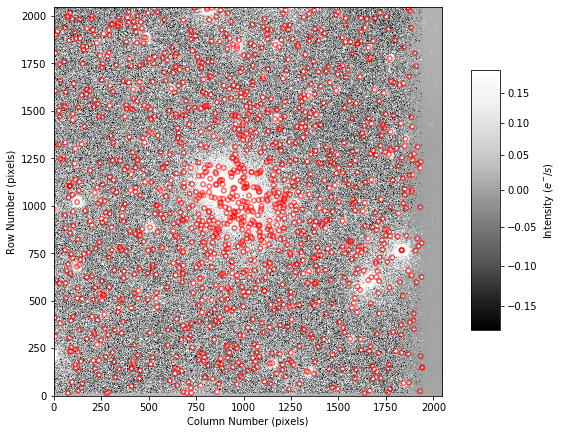

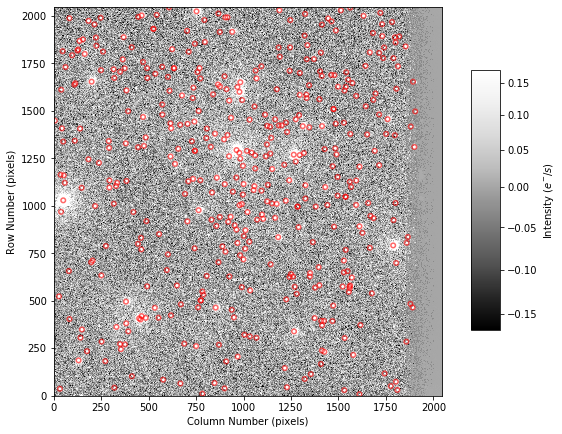

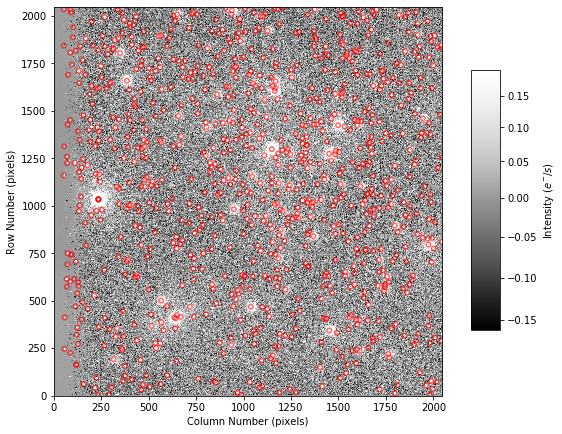

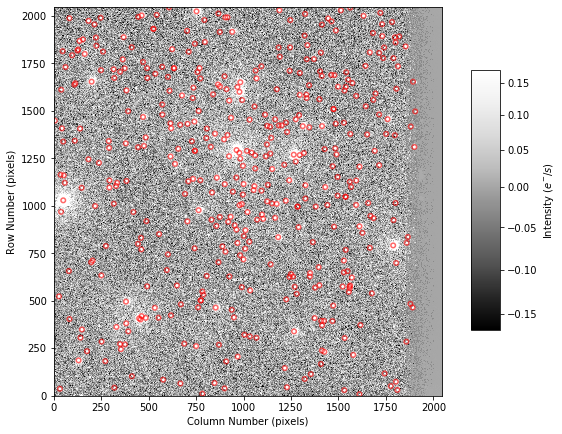

In [48]:
#***********
display_image(img_ngc7128_V_nosky, srcs=srcs_ngc7128_V, calibrated=True)
display_image(img_ngc7128_B_nosky, srcs=srcs_ngc7128_B, calibrated=True)
display_image(img_King20_V_nosky, srcs=srcs_King20_V, calibrated=True)
display_image(img_King20_B_nosky, srcs=srcs_King20_B, calibrated=True)

Now we're ready to find the astrometric solution by uploading our table of sources (actually, their x,y positions) to astrometry.net, which returns a FITS header with the transformation matrix we need / want. For this next step you'll need your astrometry.net API key, which you can find (if you're logged in) at this site http://nova.astrometry.net/api_help.

Please do not use my API key!

In [49]:
from astroquery.astrometry_net import AstrometryNet
AstrometryNet.key = 'uagwxlvkatyjhnnh'

def get_astrometry(imgfile, srcs=None, api_key=None, prefix='w', overwrite=False):
    from astropy.io import fits
    import astropy.units as u
    from astropy.coordinates import SkyCoord


    wcsfile = os.path.join(redpath, '{}{}'.format(prefix, os.path.basename(imgfile)))
    if not os.path.isfile(wcsfile) or overwrite:
        img, hdr = fits.getdata(imgfile, header=True)

        # Initialize the API.
        ast = AstrometryNet()
        if api_key:
            ast.api_key = api_key
        #ast.show_allowed_settings()

        # Get the initial position center based on the header.
        c = SkyCoord(hdr['RA']+hdr['DEC'], unit=(u.hourangle, u.deg))
        print('Initial RA, Dec = {:.5f}, {:.5f}'.format(c.ra.value, c.dec.value))

        # Query the astrometry.net engine!
        t0 = time.time()
        wcshdr = ast.solve_from_source_list(
            srcs['xcentroid'], srcs['ycentroid'], hdr['naxis1'], hdr['naxis2'],
            center_ra=c.ra.value, center_dec=c.dec.value, radius=15/60.0, 
            scale_type='ev', scale_est=0.4, scale_err=10, scale_units='arcsecperpix',
            crpix_center=True,solve_timeout=1000)
        #wcshdr = ast.solve_from_image(imgfile)
        #print('Total time = {:.3f} min'.format((time.time() - t0)/60))

        # update the original header
        for key in wcshdr.keys():
            if key not in hdr and key != 'COMMENT' and key != 'HISTORY':
                hdr[key] = wcshdr[key]

        print('Writing {}'.format(wcsfile))
        fits.writeto(wcsfile, img, header=wcshdr, overwrite=True)        
    else:
        wcshdr = fits.getheader(wcsfile)

    return wcsfile, wcshdr

This does the astrometric calibration, which means it writes a new version of your image starting with 'w' that now contains a header that allows software, e.g. DS9 to translate between pixel and sky coordinates.

To use this you will need to get an account an astrometry.net and get your own API key.  **Do not use mine**

Running this on a single image can take time

In [50]:
#***********
my_api = 'uagwxlvkatyjhnnh'
%time wcsfile, wcshdr = get_astrometry(imgfile_ngc7128_V, srcs_ngc7128_V, api_key=my_api, overwrite=False)
#%time wcsfile, wcshdr = get_astrometry(bkgsub_imname, srcs, api_key=my_api, overwrite=False)
wcshdr

Initial RA, Dec = 311.21875, 25.27056
Solving.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

TimeoutError: ('Solve timed out without success or failure', 3121282)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        353.312462075 / RA  of reference point                         
CRVAL2  =        58.48701423

In [36]:
my_api = 'uagwxlvkatyjhnnh'
%time wcsfile, wcshdr = get_astrometry(imgfile_ngc7128_B, srcs_ngc7128_B, api_key=my_api, overwrite=False)
wcshdr

CPU times: user 4.64 ms, sys: 120 µs, total: 4.76 ms
Wall time: 15.1 ms


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        353.312462075 / RA  of reference point                         
CRVAL2  =        58.48701423

In [37]:
my_api = 'uagwxlvkatyjhnnh'
%time wcsfile, wcshdr = get_astrometry(imgfile_King20_V, srcs_King20_V, api_key=my_api, overwrite=False)
wcshdr

CPU times: user 3.84 ms, sys: 424 µs, total: 4.27 ms
Wall time: 14 ms


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        353.347894319 / RA  of reference point                         
CRVAL2  =        58.48744919

In [38]:
my_api = 'uagwxlvkatyjhnnh'
%time wcsfile, wcshdr = get_astrometry(imgfile_King20_B, srcs_King20_B, api_key=my_api, overwrite=False)
wcshdr

CPU times: user 238 µs, sys: 4.08 ms, total: 4.32 ms
Wall time: 8.6 ms


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        353.312462075 / RA  of reference point                         
CRVAL2  =        58.48701423

Now repeat the necessary function calls to astrometrically calibrate all your images